In [1]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.utils import make_grid
import torchvision.models as models
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import torch.nn as nn
import torch
from torchvision.datasets import ImageFolder
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Homeworks FDS/Progetto
%pwd

/content/drive/.shortcut-targets-by-id/1Vzw8m8Ha_VscaXjjIlDjZrQtp1m45M3N/Homeworks FDS/Progetto


'/content/drive/.shortcut-targets-by-id/1Vzw8m8Ha_VscaXjjIlDjZrQtp1m45M3N/Homeworks FDS/Progetto'

- Pre-trained model
- Freeze parameters except the last layer
- Modify the last layer for binary classification

In [4]:
model = models.resnet18(pretrained=True)


for param in model.parameters():
    param.requires_grad = False
model.fc.requires_grad = True


model.fc = nn.Linear(model.fc.in_features, 1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Transformations for pre-processing MEL spectrograms (as RGB images)

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Division of the dataset into training, validation and test sets

In [6]:
class MyDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_paths = []
        self.labels = []

        for label_dir in ['artificial', 'natural']:
            label = 0 if label_dir == 'artificial' else 1
            folder = os.path.join(root_dir, label_dir)
            for filename in os.listdir(folder):
                if filename.endswith(".png") or filename.endswith(".jpg"):
                    self.file_paths.append(os.path.join(folder, filename))
                    self.labels.append(label)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = self.labels[idx]

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, label

dataset = MyDataset(root_dir='./6k_samples_dataset/dataset', transform=transform)

train_size = int(0.7*len(dataset))
val_size = int(0.2*len(dataset))
test_size = len(dataset)-train_size-val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Device configuration

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

Definition of loss function and optimizer

In [8]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.01)

Define the evalutation model

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_model(model, data_loader):
    model.eval()
    loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss += criterion(outputs, labels.float().view(-1, 1)).item()
            predicted = (outputs > 0.5).long()

            total += labels.size(0)
            correct += (predicted == labels.view(-1, 1)).sum().item()

            all_labels.extend(labels.view(-1).cpu().numpy())
            all_predictions.extend(predicted.view(-1).cpu().numpy())

    accuracy = 100 * correct / total
    avg_loss = loss / len(data_loader)

    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)

    return avg_loss, accuracy, precision, recall, f1

Define the training model and plots the metrics

In [14]:
def train_model(model, train_loader, val_loader, num_epochs=10):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.float().view(-1, 1))
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = (outputs > 0.5).long()
            total += labels.size(0)
            correct += (predicted == labels.view(-1, 1)).sum().item()

        train_accuracy = 100 * correct / total
        val_loss, val_accuracy, _, _, _ = evaluate_model(model, val_loader)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%\n")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.legend()
    plt.title("Loss per Epoch")

    plt.show()

Define the test model

In [15]:
def test_model(model, test_loader):
    test_loss, test_accuracy, precision, recall, f1 = evaluate_model(model, test_loader)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-score: {f1:.2f}")

show the results

Epoch 1/10
Train Loss: 0.1532, Train Accuracy: 94.07%
Val Loss: 0.2177, Val Accuracy: 90.08%

Epoch 2/10
Train Loss: 0.1531, Train Accuracy: 94.14%
Val Loss: 0.2737, Val Accuracy: 88.92%

Epoch 3/10
Train Loss: 0.1701, Train Accuracy: 93.33%
Val Loss: 0.1107, Val Accuracy: 95.92%

Epoch 4/10
Train Loss: 0.1332, Train Accuracy: 94.90%
Val Loss: 0.1112, Val Accuracy: 95.50%

Epoch 5/10
Train Loss: 0.1551, Train Accuracy: 94.45%
Val Loss: 0.1196, Val Accuracy: 95.42%

Epoch 6/10
Train Loss: 0.1146, Train Accuracy: 95.93%
Val Loss: 0.0912, Val Accuracy: 96.67%

Epoch 7/10
Train Loss: 0.1361, Train Accuracy: 94.88%
Val Loss: 0.1074, Val Accuracy: 95.58%

Epoch 8/10
Train Loss: 0.1126, Train Accuracy: 95.90%
Val Loss: 0.0893, Val Accuracy: 97.08%

Epoch 9/10
Train Loss: 0.1100, Train Accuracy: 95.60%
Val Loss: 0.0954, Val Accuracy: 96.58%

Epoch 10/10
Train Loss: 0.1005, Train Accuracy: 95.90%
Val Loss: 0.1388, Val Accuracy: 94.25%



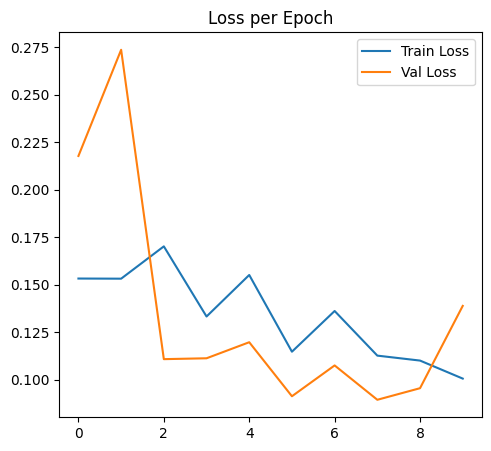

In [16]:
train_model(model, train_loader, val_loader, num_epochs=10)

In [17]:
test_model(model, test_loader)

Test Loss: 0.1092, Test Accuracy: 94.83%, Precision: 0.99%, Recall: 0.90%, Test F1-score: 0.95%,
